In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [5]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 101it [00:12,  1.98it/s]                        
Permutation explainer: 101it [00:11,  1.15it/s]                        


CPU times: user 1min 1s, sys: 3.49 s, total: 1min 4s
Wall time: 23.5 s


In [7]:
%%time
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values,
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
for class_name in comparer.class_names:
    print(class_name)
    node.focus_class = class_name
    node.calculate_counterfactuals()
with open(f'explanations/clustering.pickle', 'wb') as f:
    pickle.dump(node.state, f)

(False, False)
(False, True)
(True, False)
(True, True)
CPU times: user 7h 59min, sys: 35min 57s, total: 8h 34min 57s
Wall time: 2h 51min 51s


In [6]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions, state=state)

# Individual Explanations

In [7]:
node.focus_class = None
classes = ['True']

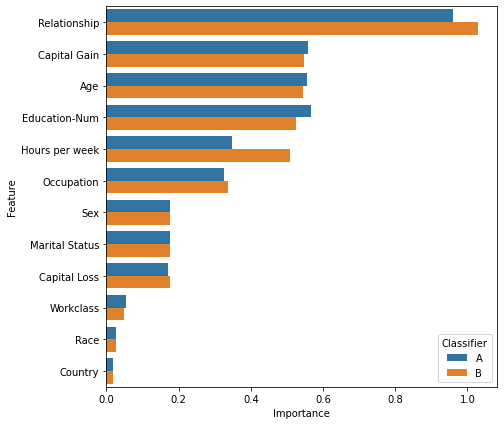

In [8]:
_, feature_importances_a = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
_, feature_importances_b = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
feature_order, _ = calc_feature_order(indiv_shap_values)
feature_idx = pd.Index(feature_names, name='Feature')
feature_importances_a = pd.Series(feature_importances_a.values, index=feature_idx, name='Importance')
feature_importances_b = pd.Series(feature_importances_b.values, index=feature_idx, name='Importance')
feature_importances = pd.concat({'A': feature_importances_a, 'B': feature_importances_b}, names=['Classifier'])
feature_importances = pd.DataFrame(feature_importances, columns=['Importance']).reset_index()
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(orient='h', data=feature_importances, y='Feature', x='Importance', hue='Classifier', order=feature_names[feature_order], ax=ax)
plt.savefig('figures/adult-indiv-featimp.pdf', bbox_inches='tight', pad_inches=0)

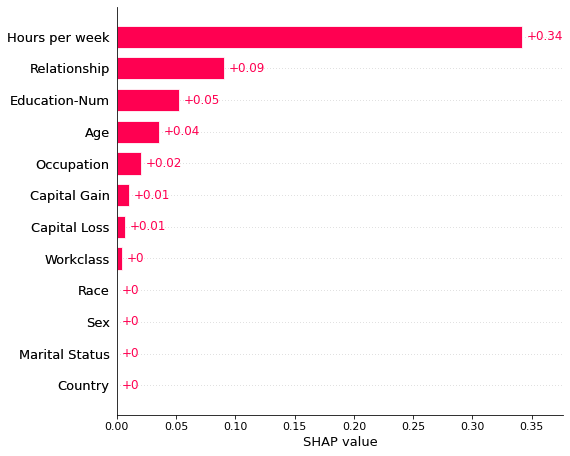

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)
plt.savefig('figures/adult-diff-feat-imp.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
from clustering import plot_indiv_dependence_curve_comparison_for_feature, _DEFAULT_FIGSIZE

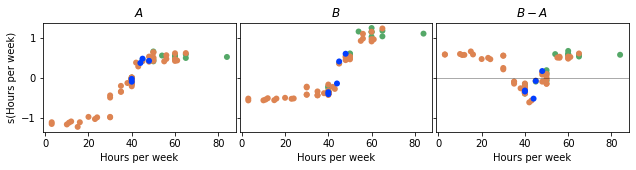

In [11]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, figsize=(3*figsize[0], 1*figsize[1]), squeeze=False, constrained_layout=True, sharex='all', sharey='all')
node.plot_indiv_feature_dependence('Hours per week', classes=classes, axs=axs.T)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s(Hours per week)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
plt.savefig('figures/adult-indiv-depplots-hours.pdf', bbox_inches='tight', pad_inches=0)

B generally overestimates the effect of Hours per week on the outcome, except around approx. 40. Here, it underestimates its effect.

In [12]:
def get_diff_explained(feature, label='True'):
    values = node.diff_shap_values[node.highlight, feature, label].values
    feature = node.data.loc[node.highlight, feature]
    explained = pd.DataFrame({'s_d': values, 'f': feature}, index=node.instance_indices[node.highlight])
    return explained

In [13]:
explained = get_diff_explained('Hours per week')
explained

,s_d,f
34,-0.069337,45.0
49,-0.332852,40.0
54,-0.510184,44.0
53,0.175950,48.0
60,-0.308679,40.0


Instance \#54 is at the peak of the underestimation. But the difference SHAP Value of instance \#53 is even positive. It also does not seem a sufficient explanation for the other instances, which are closer to 0. But on a closer look at its average prediction of class 1's outcome, it becomes clear that the general overestimation of the effect of Hours per week on class 1's outcome is a form of compensation, because B's average prediction is lower than A's by approx. 0.5 and B is overestimating Hours per week's effect by approx. 0.5 as well.

I conclude, that B generally overestimates the effect of Hours per week values on the outcome compared to A, nevertheless it predicts class 1 later than A.

In [14]:
node.diff_shap_values[:, :, 1].base_values[0]

-0.534588186740875

In [15]:
node.indiv_shap_values[:, :, 'A.True'].base_values[0], node.indiv_shap_values[:, :, 'B.True'].base_values[0]

(-1.786556739807129, -2.321144926548004)

But B's average prediction of class 1's outcome is lower lower than A's by more than 0.5.

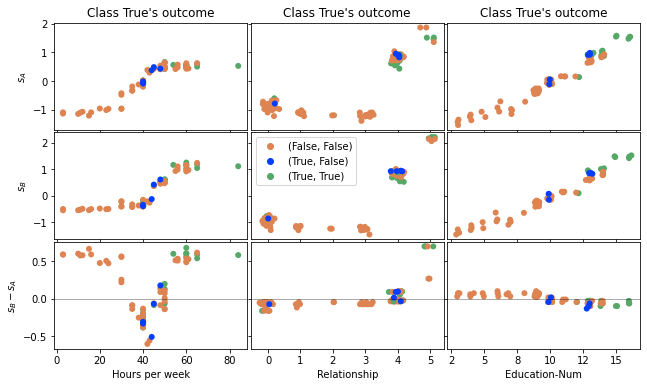

In [16]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3*figsize[0], 3*figsize[1]), squeeze=False, constrained_layout=True, sharex='col', sharey='row')
plot_indiv_dependence_curve_comparison_for_feature(node, 'Hours per week', classes, axs=axs.T[0:1].T, show_legend=False)
plot_indiv_dependence_curve_comparison_for_feature(node, 'Relationship', classes, axs=axs.T[1:2].T, show_legend=False)
plot_indiv_dependence_curve_comparison_for_feature(node, 'Education-Num', classes, axs=axs.T[2:3].T, show_legend=False)
for row in range(3):
    for col in range(1, 3):
        axs[row][col].set_ylabel(None)
for row in range(2):
    axs[row][0].set_ylabel(axs[row][0].get_ylabel().split('(')[0])
axs[1][1].legend()
plt.savefig('figures/adult-indiv-depplots.pdf', bbox_inches='tight', pad_inches=0)

In [17]:
node.data.loc[node.highlight, 'Education-Num']

34    13.0
49    13.0
54    13.0
53    10.0
60    10.0
Name: Education-Num, dtype: float64

In [18]:
node.data['Education-Num'].describe()

count    100.00000
mean      10.10000
std        2.90767
min        3.00000
25%        9.00000
50%       10.00000
75%       13.00000
max       16.00000
Name: Education-Num, dtype: float64

For four instances classified differently, B underestimates the outcome.

In [19]:
def estimate_change(explained, instances, df=None):
    if df is None:
        y_pred = comparer.predict_combined_log_odds(node.data[node.highlight])
        df = pd.DataFrame(y_pred, index=node.instance_indices[node.highlight], columns=indiv_shap_values.output_names)
        df = df.loc[:, ['A.True', 'B.True']]
        df['B.True*'] = df['B.True']
    df.loc[instances, 'B.True*'] -= explained.loc[instances, 's_d']
    return df

In [20]:
instances = [idx for idx in node.instance_indices[node.highlight] if not idx == 53]
df = estimate_change(explained, instances)
df

,A.True,B.True,B.True*
34,0.517855,-0.085566,-0.016229
49,0.386011,-0.518131,-0.185279
54,0.752322,-0.304051,0.206134
53,0.083908,-0.164512,-0.164512
60,0.513691,-0.417922,-0.109243


This is enough to explain why instance \#54 was classified differently, but not the others.

In [21]:
explained = get_diff_explained('Relationship')
explained

,s_d,f
34,0.089391,4.0
49,-0.035097,4.0
54,0.013914,4.0
53,0.094920,4.0
60,-0.074071,0.0


B underestimates slightly for Relationship = 0

In [22]:
instances = [idx for idx in node.instance_indices[node.highlight] if idx in [60]]
df = estimate_change(explained, instances, df)
df

,A.True,B.True,B.True*
34,0.517855,-0.085566,-0.016229
49,0.386011,-0.518131,-0.185279
54,0.752322,-0.304051,0.206134
53,0.083908,-0.164512,-0.164512
60,0.513691,-0.417922,-0.035172


In [23]:
explained = get_diff_explained('Education-Num')
explained

,s_d,f
34,-0.099043,13.0
49,-0.063222,13.0
54,-0.132600,13.0
53,0.015622,10.0
60,-0.044914,10.0


In [24]:
instances = explained.index[explained['f'] > 10]
df = estimate_change(explained, instances, df)
df

,A.True,B.True,B.True*
34,0.517855,-0.085566,0.082814
49,0.386011,-0.518131,-0.122057
54,0.752322,-0.304051,0.338733
53,0.083908,-0.164512,-0.164512
60,0.513691,-0.417922,-0.035172


B underestimates high Education-Num > 10, which explains why \#34 was classified differently

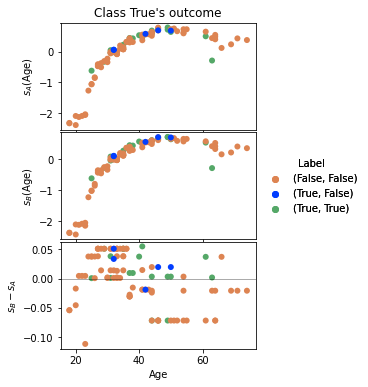

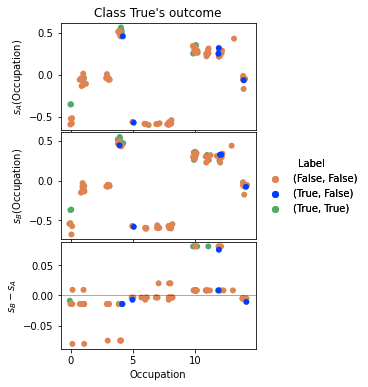

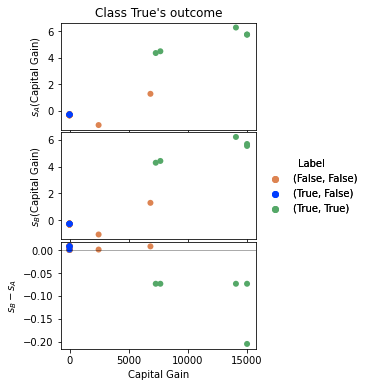

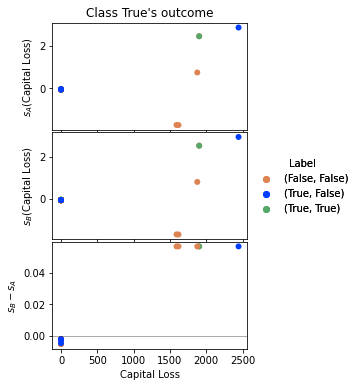

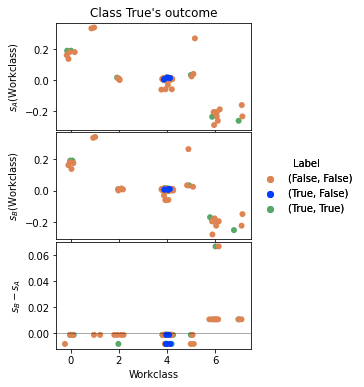

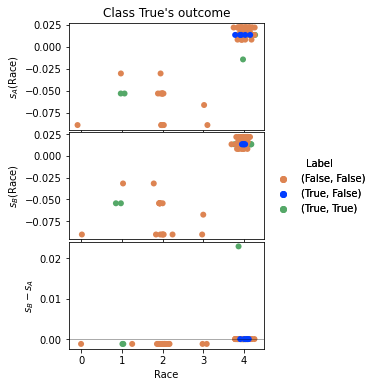

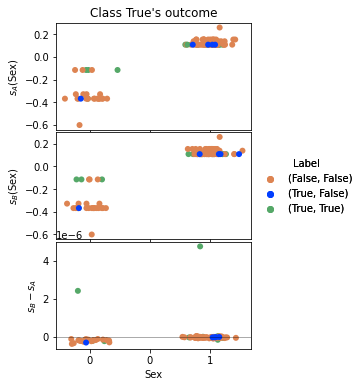

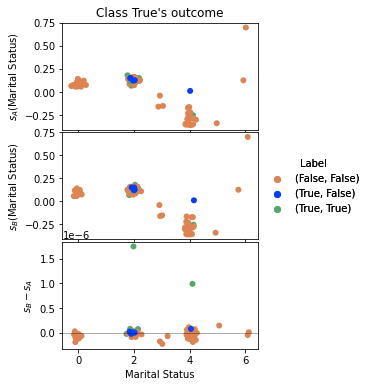

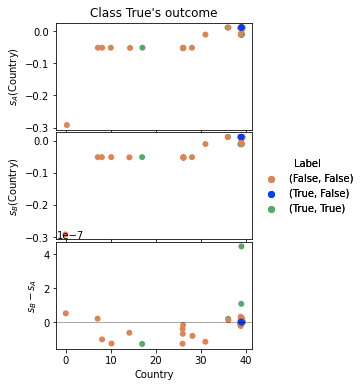

In [25]:
node.plot_indiv_feature_dependence(*feature_names[node.diff_feature_order][3:], classes=classes, separate_rows=True)

# Difference Classifier Explanations

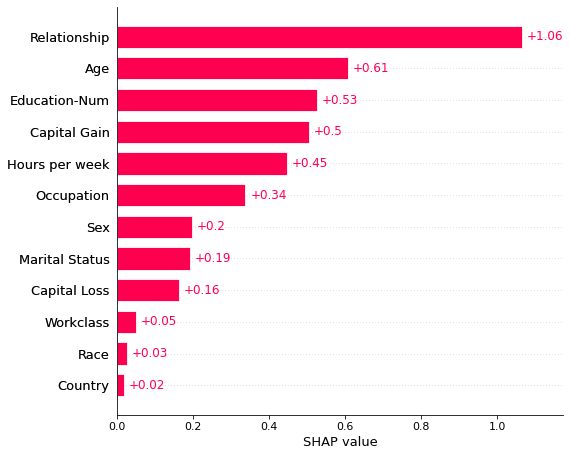

In [26]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

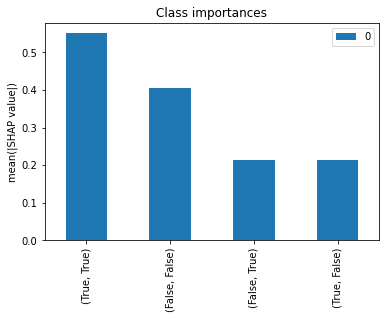

In [88]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, comparer.class_names)

## Clustering of Class $(True, False)$ SHAP Values

In [27]:
node.focus_class = '(True, False)'
classes = ['(False, False)', '(True, False)', '(True, True)']
node.class_counts, node.distance

((False, False)    78
 (True, True)      17
 (True, False)      5
 dtype: int64,
 281.1685447247144)

### Main Node (RL)

In [28]:
node = node.root.descend()
node, node.class_counts, node.distance

(RL,
 (False, False)    33
 (True, True)      12
 (True, False)      5
 dtype: int64,
 79.28268292947294)

In [29]:
print(node.rule_from_counterfactuals()[0])

`Education-Num` > 8 and Age > 26 and 34 < `Hours per week` <= 54 and `Capital Gain` <= 56


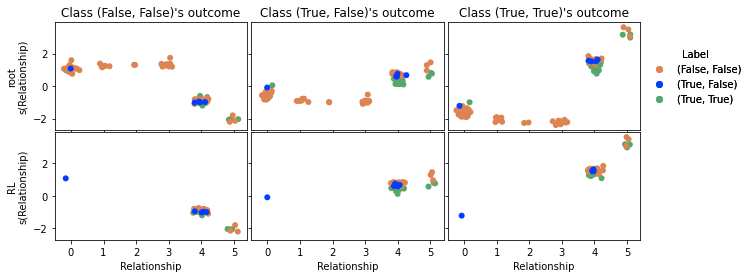

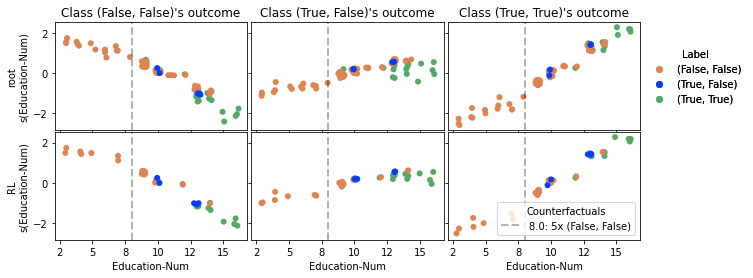

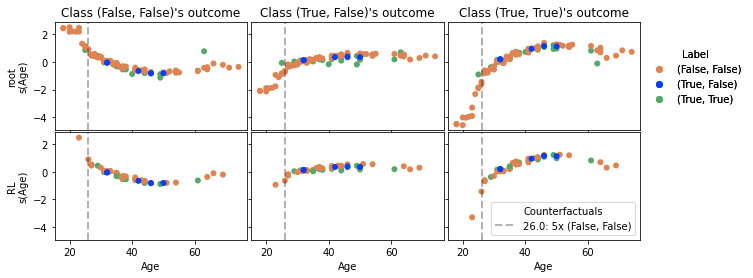

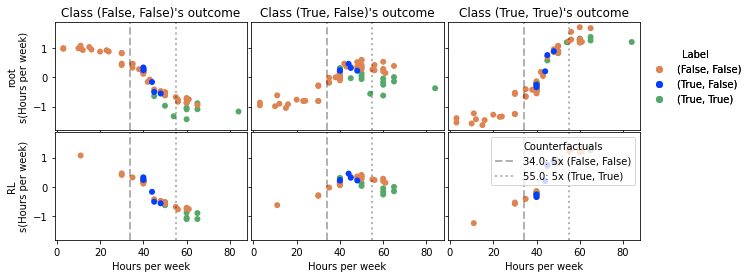

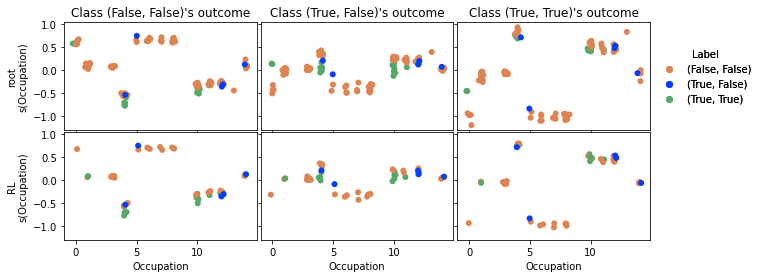

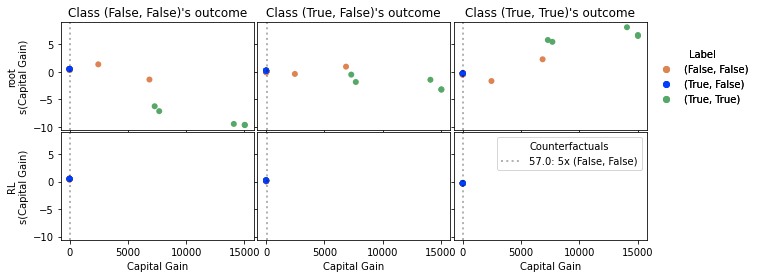

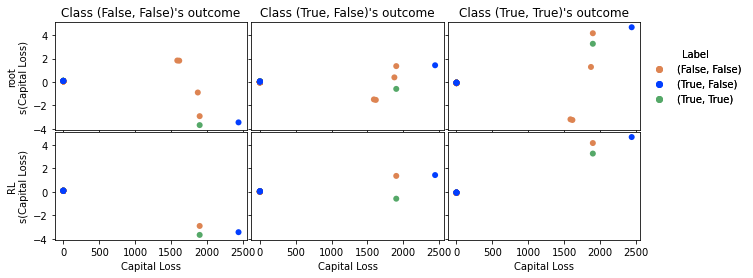

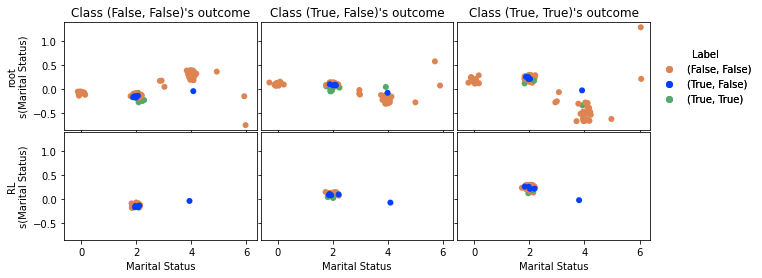

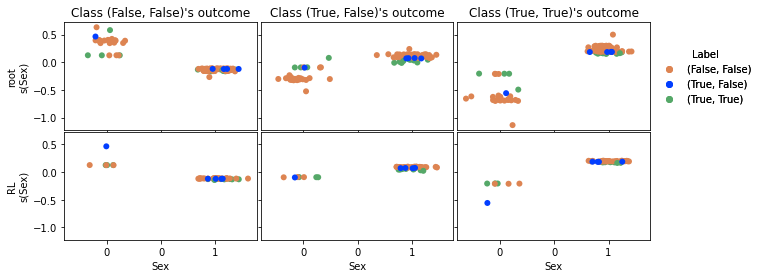

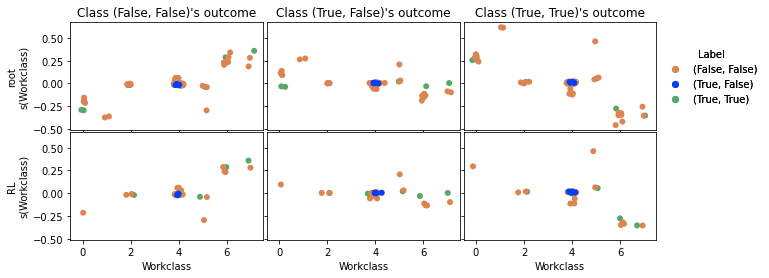

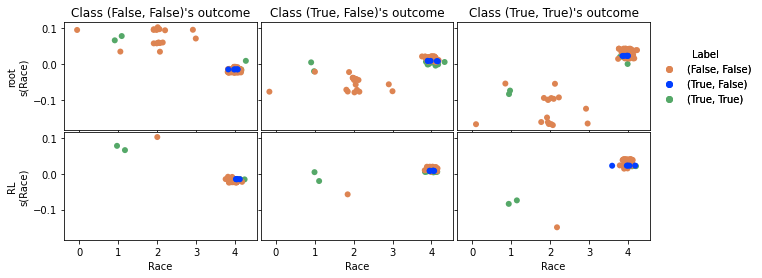

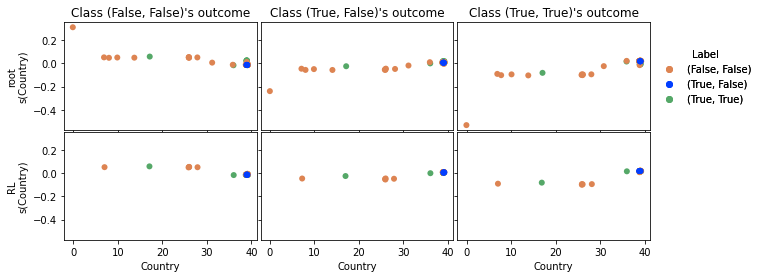

In [30]:
node.root.plot_feature_dependence(focus=node, classes=classes)

### Node 1 (RLRRR)

In [31]:
path = [node]
node = node.get_right().descend()
node, node.class_counts, node.distance

(RLRRR,
 (True, False)    1
 dtype: int64,
 0)

In [32]:
print(node.rule_from_counterfactuals()[0])

`Capital Loss` > 2384 and Relationship <= 2 and Age > 35 and 2 < Occupation <= 4 and Sex <= 0 and `Capital Gain` <= 56 and 34 < `Hours per week` <= 44 and 8 < `Education-Num` <= 12


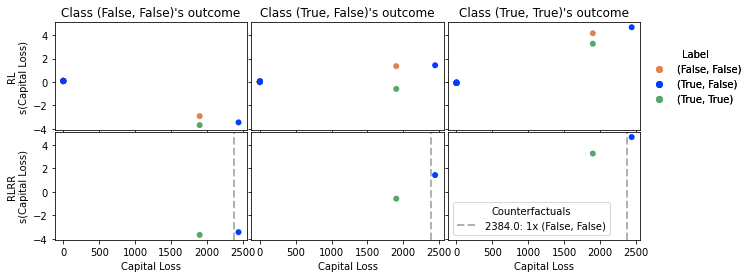

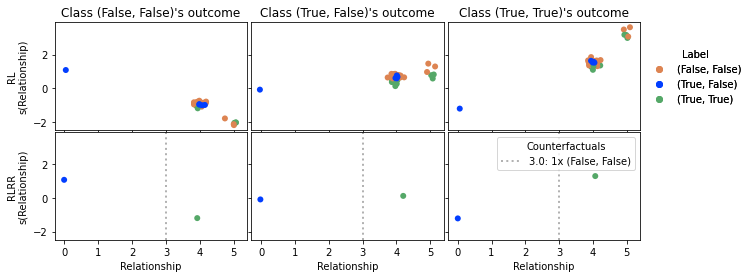

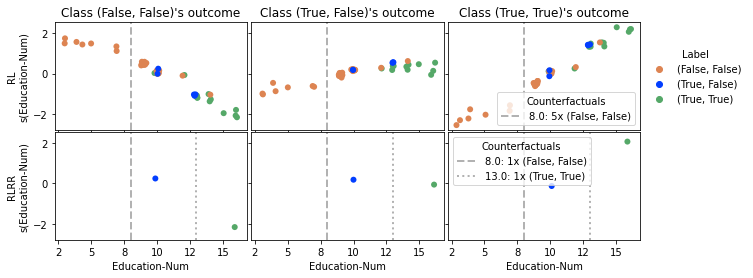

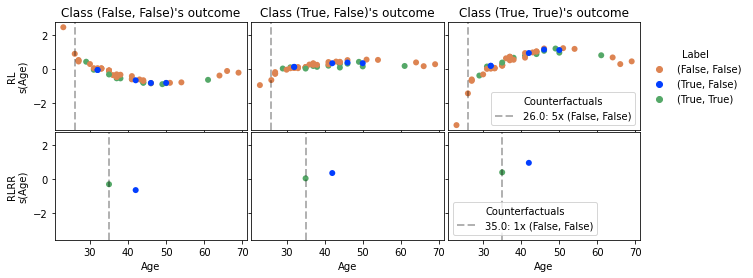

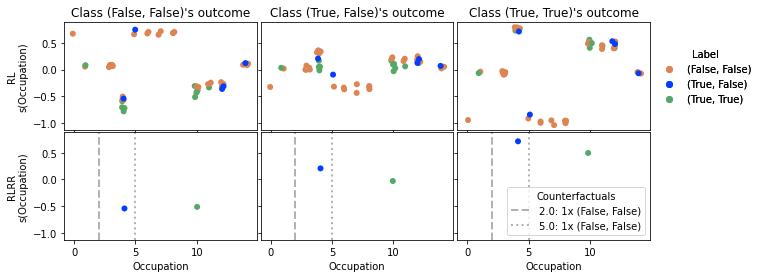

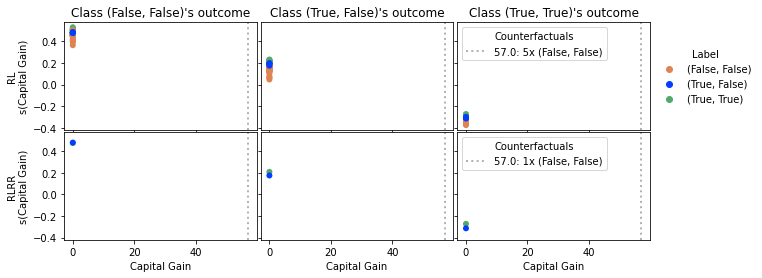

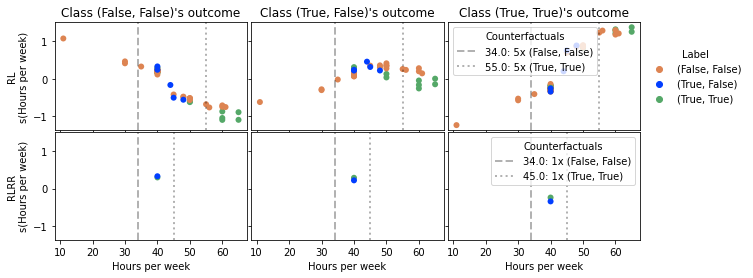

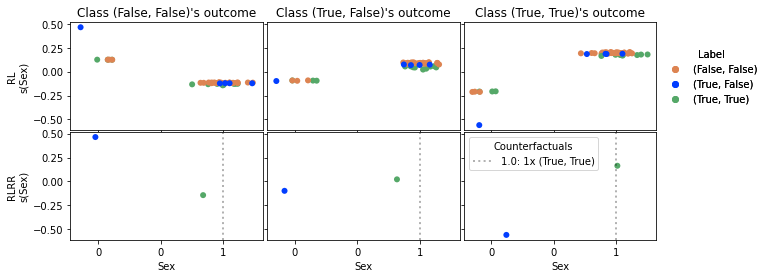

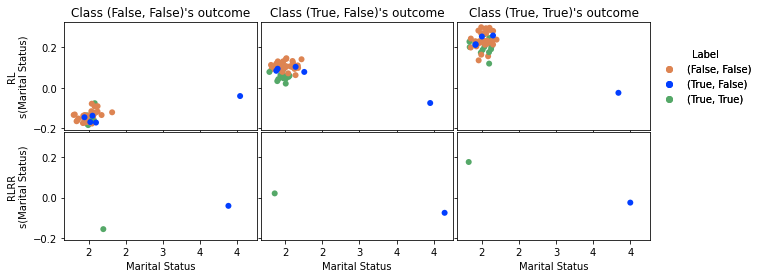

In [33]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:9], focus=node.parent, classes=classes)

In [34]:
X = node.data[node.highlight].copy()
X['Relationship'] = 4
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

In [35]:
X = node.data[node.highlight].copy()
X['Relationship'] = 5
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

### Node 2 (RLL)

In [36]:
node = path[-1].left.descend()
node, node.class_counts, node.distance

(RLL,
 (False, False)    32
 (True, True)      11
 (True, False)      4
 dtype: int64,
 51.498931921916956)

In [37]:
print(node.rule_from_counterfactuals()[0])

Relationship > 3 and `Education-Num` > 9 and 34 < `Hours per week` <= 54 and Age > 26 and `Capital Gain` <= 56 and `Capital Loss` <= 1447


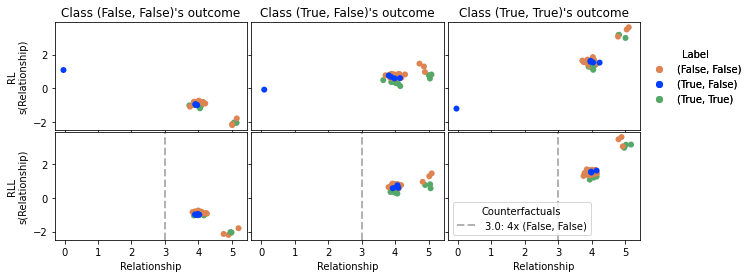

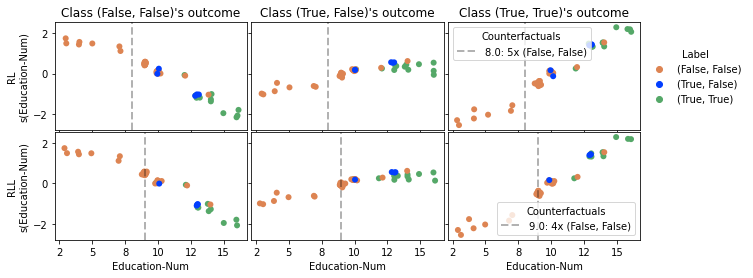

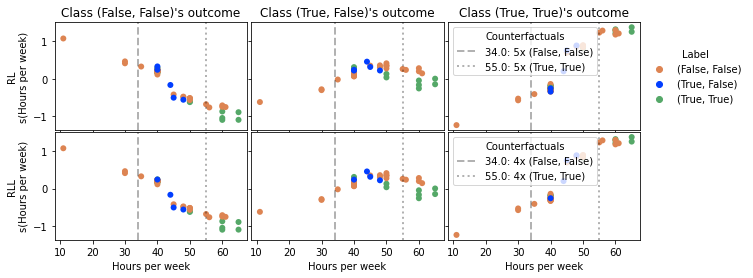

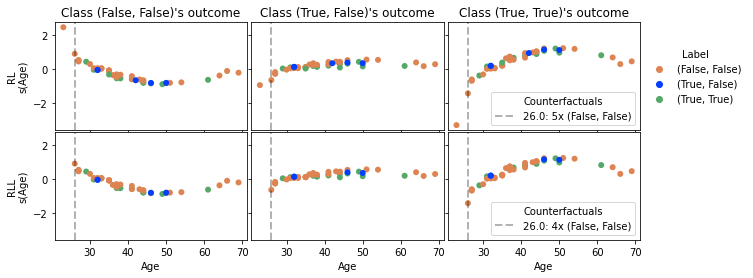

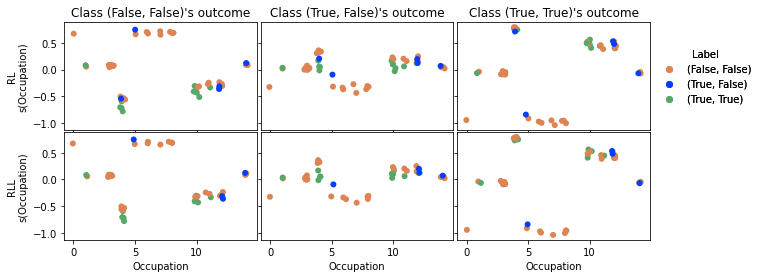

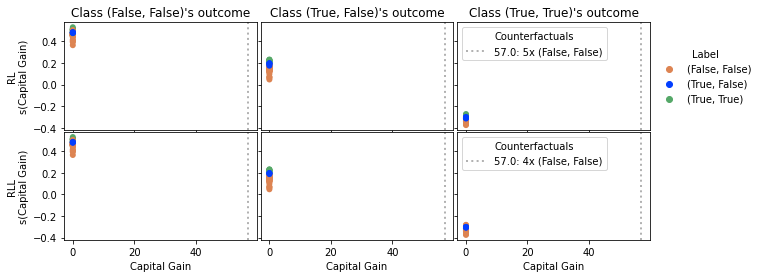

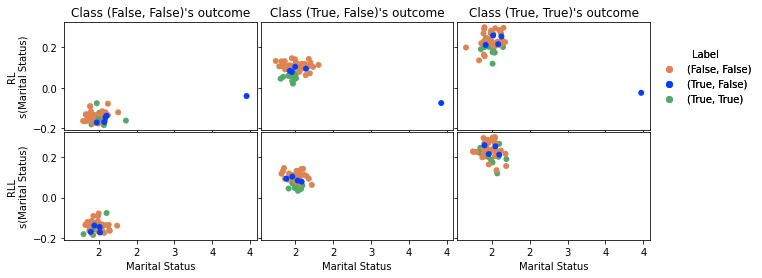

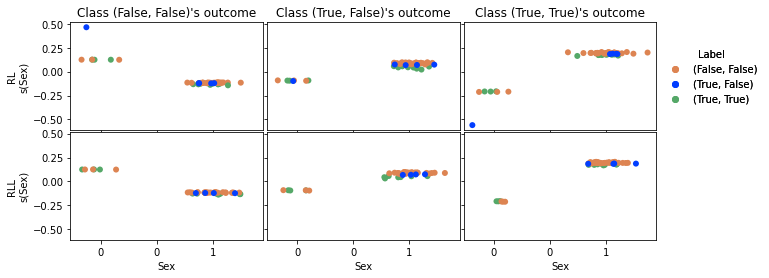

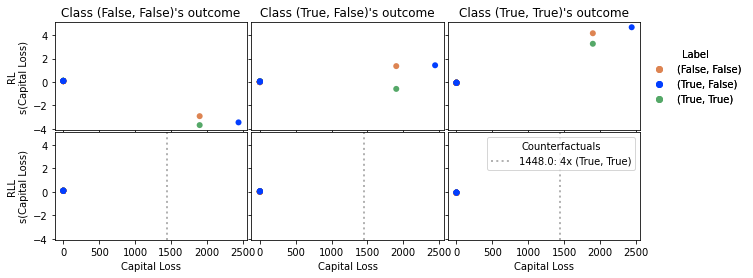

In [38]:
path[-1].plot_feature_dependence(*node.features_ordered[:-3], focus=node, classes=classes);

### Node 2.1 (RLLRRRRRL)

In [39]:
path.append(node)
node = node.right.descend()
node, node.class_counts, node.distance

(RLLRRRRRL,
 (True, False)    1
 dtype: int64,
 0)

In [40]:
print(node.rule_from_counterfactuals()[0])

Relationship > 3 and 44 < Age <= 59 and 44 < `Hours per week` <= 54 and `Capital Gain` <= 56 and 9 < `Education-Num` <= 11 and `Marital Status` <= 2 and Sex > 0 and Occupation > 13 and `Capital Loss` <= 1447 and 1 < Workclass <= 5 and Country > 0


In [41]:
node = node.root.get('RLLRRRRRL')

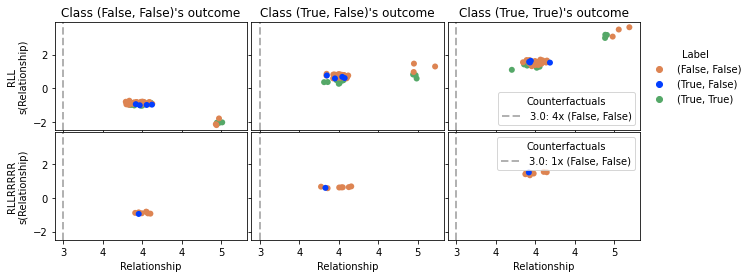

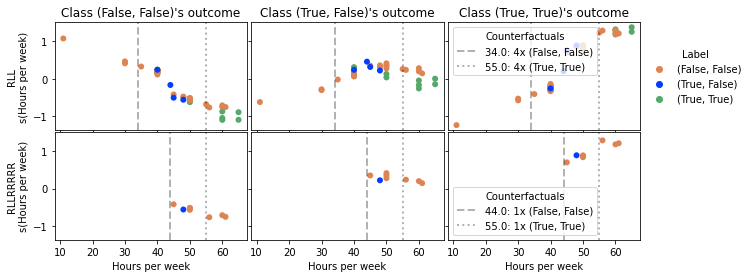

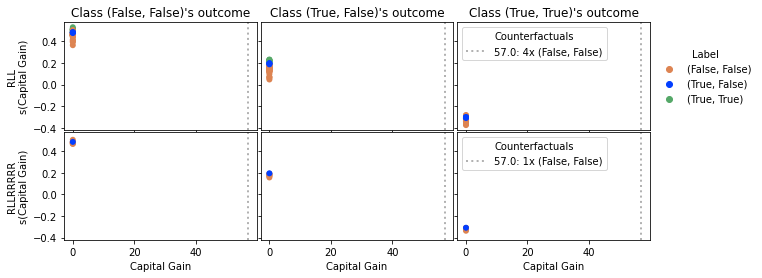

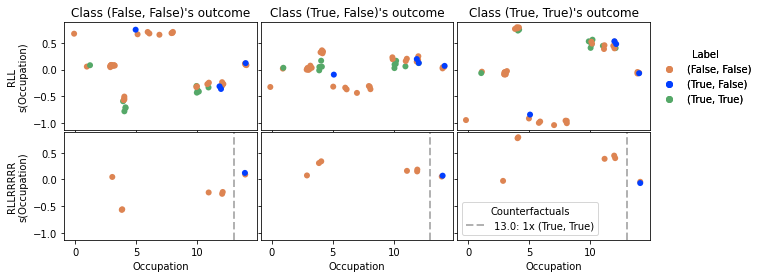

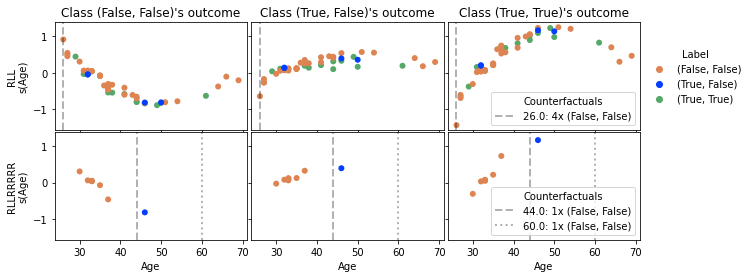

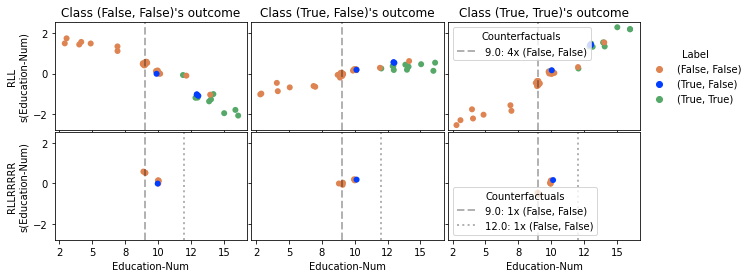

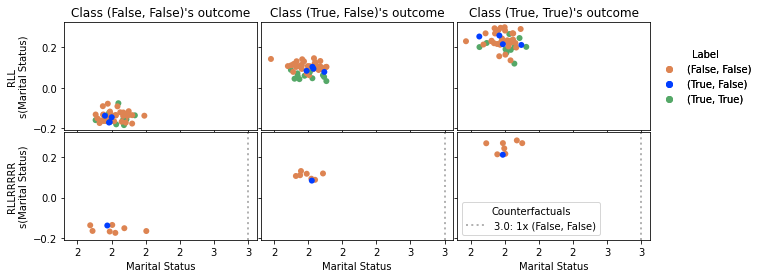

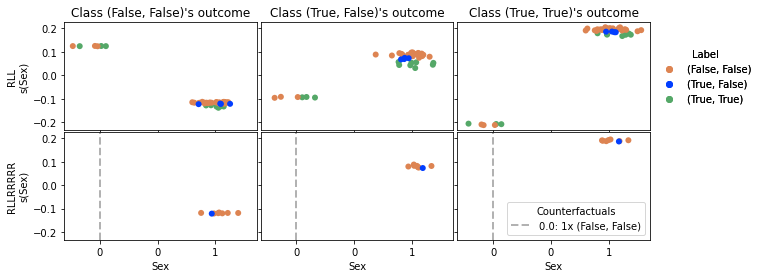

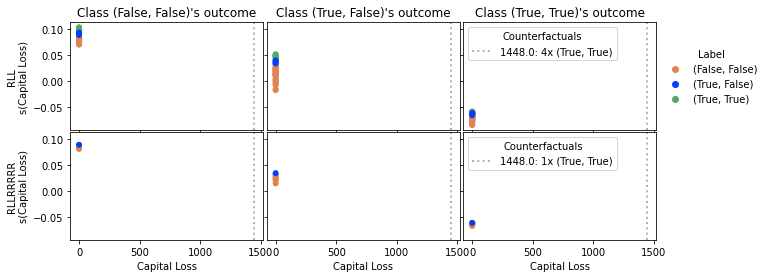

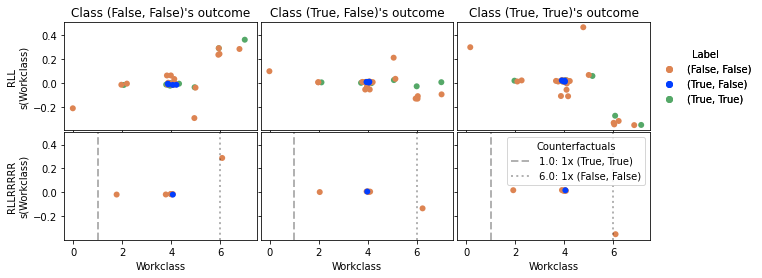

In [42]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:-2], focus=node.parent, classes=classes);

In [43]:
X = node.data[node.highlight].copy()
X['Education-Num'] = 13
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

### Node 2.2 (RLLL)

In [44]:
node = path[-1].left.descend()
node, node.class_counts, node.distance

(RLLL,
 (True, True)      9
 (True, False)     3
 (False, False)    1
 dtype: int64,
 20.43439220003462)

In [45]:
print(node.rule_from_counterfactuals()[0])

3 < Relationship <= 4 and `Education-Num` > 12 and 34 < `Hours per week` <= 45 and Age > 26 and `Capital Gain` <= 56 and `Capital Loss` <= 1447


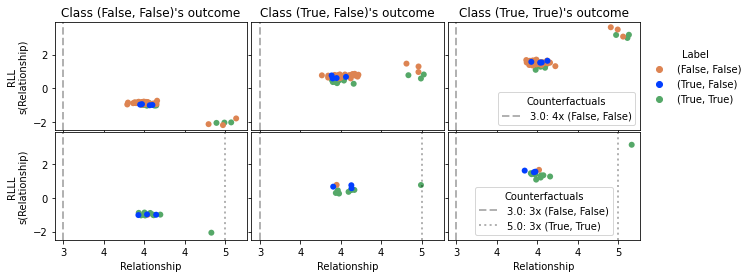

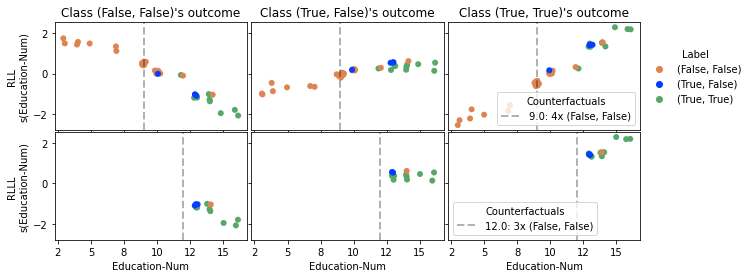

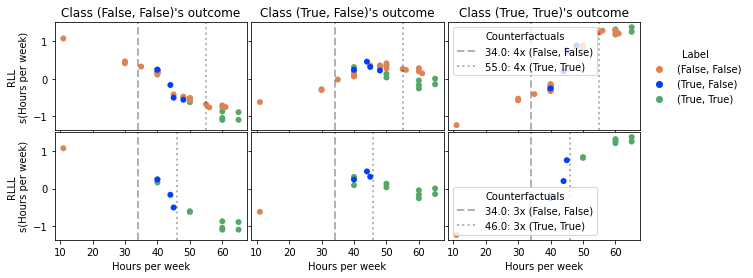

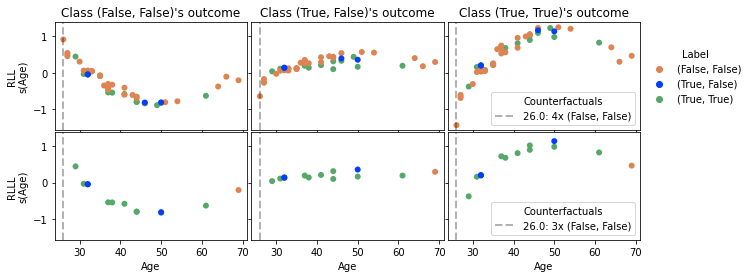

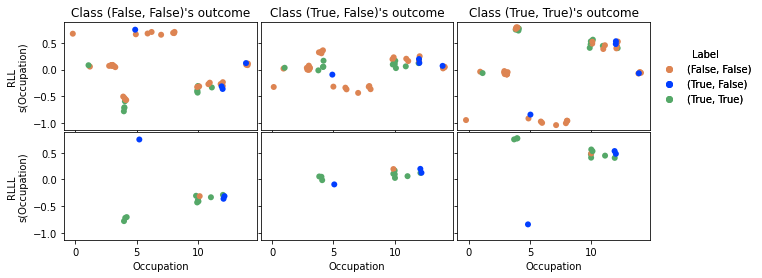

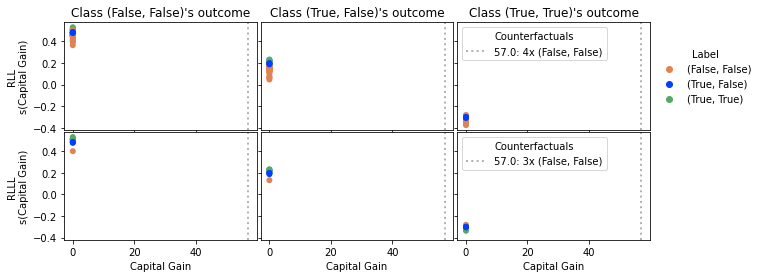

In [46]:
path[-1].plot_feature_dependence(*node.features_ordered[:-6], focus=node, classes=classes);

# Evaluation

In [7]:
with open('data/test.pickle', 'rb') as f:
    X_test, X_test_display, y_test = pickle.load(f)

In [48]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Permutation explainer: 4786it [09:09,  8.68it/s]                          


CPU times: user 20min 53s, sys: 1min 49s, total: 22min 43s
Wall time: 9min 9s


In [8]:
with open('explanations/test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [9]:
metrics = eval_clusterings(node, X_test, shap_values_test)
metrics.describe()

,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.804997,0.769655,0.757001,2994.913043,21.202899,46.347826,25.078940
std,0.253394,0.228710,0.240616,1460.290440,16.708205,34.715154,59.083253
min,0.000000,0.000000,0.000000,238.000000,1.000000,0.000000,0.000000
25%,0.761235,0.743066,0.649024,685.000000,7.000000,20.000000,1.858812
50%,0.937398,0.893098,0.914984,3854.000000,17.000000,42.000000,5.362787
75%,0.948697,0.905293,0.927082,3854.000000,34.000000,67.000000,19.821589
max,0.984682,1.000000,0.931742,3854.000000,78.000000,186.000000,281.168545


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

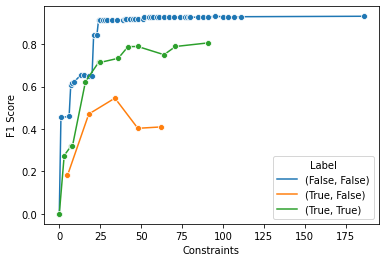

In [10]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [11]:
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [57]:
for label in comparer.class_names:
    print(label)
    display(metrics[metrics['Label'] == label].describe())

(False, False)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000
mean,0.899270,0.790602,0.835331,3854.0,26.529412,50.901961,15.895853
std,0.148968,0.210033,0.184516,0.0,16.195497,36.335798,40.953455
min,0.000000,0.000000,0.000000,3854.0,1.000000,0.000000,0.000000
25%,0.932896,0.828620,0.878639,3854.0,13.500000,23.500000,1.887546
50%,0.945604,0.893617,0.918602,3854.0,26.000000,46.000000,4.409439
75%,0.949653,0.905293,0.927179,3854.0,38.500000,75.500000,12.833094
max,0.984682,0.907109,0.931742,3854.0,78.000000,186.000000,281.168545


(False, True)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(True, False)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000
mean,0.492140,0.585714,0.402235,238.0,3.000000,33.400000,73.715257
std,0.279838,0.321800,0.136198,0.0,1.581139,22.777182,117.494457
min,0.100177,0.277311,0.181235,238.0,1.000000,5.000000,0.000000
25%,0.319759,0.285714,0.403561,238.0,2.000000,18.000000,14.144280
50%,0.568182,0.525210,0.409938,238.0,3.000000,34.000000,21.633290
75%,0.686869,0.890756,0.470588,238.0,4.000000,48.000000,51.630170
max,0.785714,0.949580,0.545852,238.0,5.000000,62.000000,281.168545


(True, True)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000
mean,0.555484,0.758226,0.586152,685.0,7.307692,33.461538,42.398620
std,0.315091,0.248964,0.264378,0.0,4.516352,28.585006,80.761769
min,0.000000,0.000000,0.000000,685.0,1.000000,0.000000,0.000000
25%,0.189974,0.743066,0.317922,685.0,4.000000,8.000000,1.194865
50%,0.660870,0.776642,0.714094,685.0,7.000000,25.000000,9.034139
75%,0.839934,0.845255,0.788536,685.0,10.000000,48.000000,28.210025
max,0.916357,1.000000,0.806214,685.0,17.000000,91.000000,281.168545


# Additional plots

Moving B by -10 hours and -0.6 log odds places one curve above the other.

In [7]:
from clustering import _DEFAULT_FIGSIZE

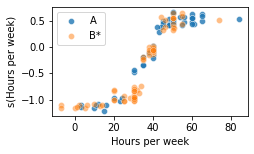

In [86]:
fig, ax = plt.subplots(figsize=(_DEFAULT_FIGSIZE[0], _DEFAULT_FIGSIZE[1]))
s = indiv_shap_values[:, 'Hours per week']
sns.scatterplot(x=s.data, y=s[:, 'A.True'].values, label='A', alpha=0.8, ax=ax)
sns.scatterplot(x=s.data - 10, y=s[:, 'B.True'].values - 0.6, label='B*', alpha=0.5, ax=ax)
ax.set_xlabel('Hours per week')
ax.set_ylabel('s(Hours per week)')
plt.savefig('figures/adult-indiv-depplots-moved.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
node = node.root
node.focus_class = '(True, False)'
classes = ['(False, False)', '(True, False)', '(True, True)']

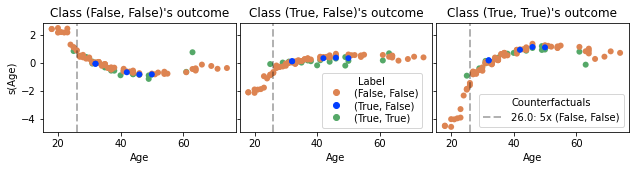

In [67]:
node.plot_feature_dependence('Age', classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[0]
fig.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label',
           loc='center', bbox_to_anchor=(0.56, 0.34),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/adult-global-depplots-10-age.pdf', bbox_inches='tight', pad_inches=0)

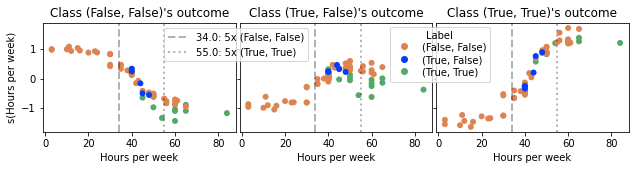

In [68]:
node.plot_feature_dependence('Hours per week', classes=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[2]
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(*filter_paths(handles, labels), loc='center', bbox_to_anchor=(0.38, 0.73))
fig.legend(*filter_lines(handles, labels), title='Label',
           loc='center', bbox_to_anchor=(0.65, 0.66),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/adult-global-depplots-10-hours.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
from clustering import plot_dependence_curves_for_nodes

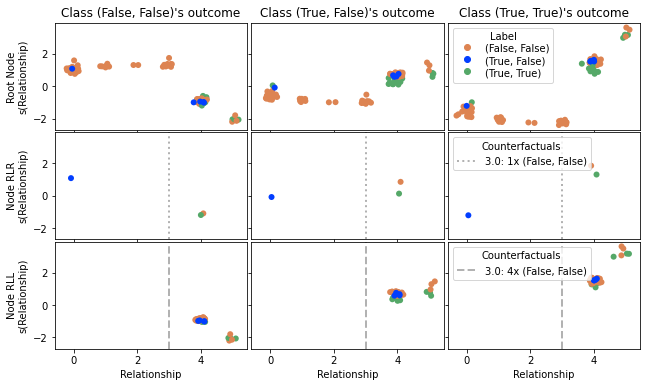

In [10]:
plot_dependence_curves_for_nodes(node, node.descend().get_right(), node.descend().get_left(),
                                 feature='Relationship', labels=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label',
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/adult-depplots-10-relationship.pdf', bbox_inches='tight', pad_inches=0)

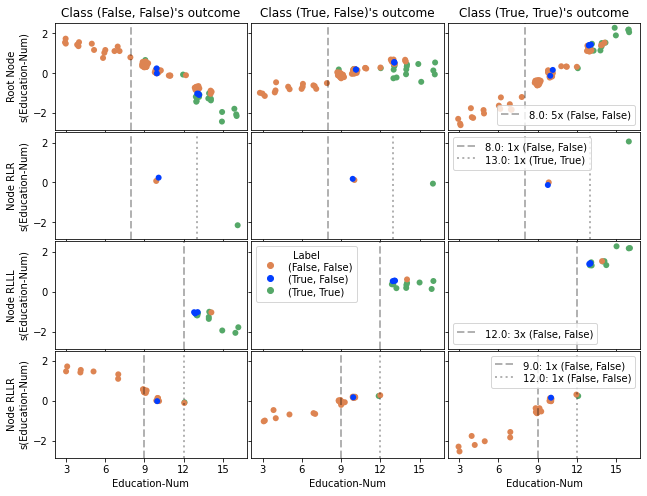

In [11]:
plot_dependence_curves_for_nodes(node, node.descend().get_right(),
                                 node.descend().get_left().descend().get_left(),
                                 node.descend().get_left().descend().get_right(),
                                 feature='Education-Num', labels=classes, show_legend=False)
fig = plt.gca().figure
ax = fig.axes[2]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
ax = fig.axes[5]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
ax = fig.axes[8]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
ax = fig.axes[11]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()),
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
ax = fig.axes[7]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label',
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/adult-depplots-10-education.pdf', bbox_inches='tight', pad_inches=0)

In [72]:
nodes = dict([(name, node.root.get(cluster)) for name, cluster in
              [
                  ('Main Node', ''),
                  ('Node 1', 'RLR'),
                  ('Node 2', 'RLL'),
                  ('Node 2.1', 'RLLR'),
                  ('Node 2.2', 'RLLL')
              ]
             ])

In [73]:
for name, node in nodes.items():
    rule = node.rule_from_counterfactuals(latex=True)[0]
    print(f'\item \emph{{{name}}}: ${rule}$')

\item \emph{Main Node}: $\text{Age} > 26 \land \text{Education-Num} > 8 \land \text{Capital Gain} \leq 56 \land 34 < \text{Hours per week} \leq 54$
\item \emph{Node 1}: $\text{Capital Loss} > 2384 \land \text{Age} > 35 \land \text{Relationship} \leq 2 \land 8 < \text{Education-Num} \leq 12 \land 2 < \text{Occupation} \leq 4 \land \text{Capital Gain} \leq 56 \land 34 < \text{Hours per week} \leq 44 \land \text{Sex} \leq 0$
\item \emph{Node 2}: $\text{Relationship} > 3 \land \text{Education-Num} > 9 \land 34 < \text{Hours per week} \leq 54 \land \text{Age} > 26 \land \text{Capital Gain} \leq 56 \land \text{Capital Loss} \leq 1447$
\item \emph{Node 2.1}: $\text{Relationship} > 3 \land 9 < \text{Education-Num} \leq 11 \land 44 < \text{Age} \leq 59 \land 44 < \text{Hours per week} \leq 54 \land \text{Occupation} > 13 \land \text{Capital Gain} \leq 56 \land \text{Marital Status} \leq 2 \land \text{Sex} > 0 \land \text{Capital Loss} \leq 1447 \land 1 < \text{Workclass} \leq 5 \land \text{Coun

In [74]:
from clustering import eval_clusterings_for_class

In [75]:
nodes = [node.root.get(cluster) for cluster in ['RLR', 'RLLR', 'RLLL']]
eval_clusterings_for_class('(True, False)', nodes, X_test, shap_values_test)

Precision           0.568182
Recall               0.52521
F1 Score            0.545852
Support                238.0
Label          (True, False)
Nodes                      3
Constraints               34
Name: True, dtype: object